# Project on Example title

## Imports

In [1]:
%matplotlib inline
import scipy.stats as sts
import numpy as np
import heapq
from scipy.special import factorial
import matplotlib.pyplot as plt

Status = {True:"Idle",False:"Busy"}
ActiveStatus = {True:"Active",False:"Inactive"}

### Server class

In [2]:
class Server:
    def __init__(self,id):
        self.id = id
        self.idle = True

    def setIdle(self):
        self.idle = True

    def setBusy(self):
        self.idle = False
        
    def __repr__(self):
        return "Server {} is {}".format(self.id,Status[self.idle])

### Arrival process class

In [3]:
class ArrivalProcess:
    def __init__(self,id):
        self.id = id
        self.active = True # corresponds to States[indx] = 1
        self.idle = False # corresponds to As[indx] = 1
        
    def setActive(self):
        self.active = True
    
    def setInactive(self):
        self.active = False
        
    def setIdle(self):
        self.idle = True
        
    def setBusy(self):
        self.idle = False
        
    def __repr__(self):
        return "ArrivalProcess {}, is {} and {}".format(self.id,ActiveStatus[self.active],Status[self.idle])

### Queue class

In [4]:
class Queue:
    def __init__(self,size=None):
        self.size = size
        self.Q = []
        self.Qlen = []
        self.Qtime = []
        
    def isempty(self):
        if self.Q:
            return False
        else:
            return True
    
    def depositToQueue(self,arrtime):
        #arrtime is the arrival time
        if arrtime:
            if self.size and self.size < len(self.Q)+1:
                return False
            else:
                self.Q.append(arrtime)
                self.Qlen.append([arrtime,len(self.Q)])
                return True
    
    def drawFromQueue(self,Time):
        #Time is current time
        q0 = self.Q.pop(0)
        self.Qtime.append(Time-q0)
        if self.Q:
            self.Qlen.append([Time,len(self.Q)])
        else:
            self.Qlen.append([Time,0])
    
    def generateQueueTime(self,num=1):
        if self.queueTime:
            return self.queueTime(num)
        else:
            return 0

### Simulation class

In [5]:
class Simulation:
    def __init__(self,num_servers,interarrival,service,stateGen=None,superpositions=1,queue_size=None):
        # Number of servers
        self.num_servers = num_servers
        self.servers = [Server(i) for i in range(num_servers)]
        
        # Queue
        # if queue_size is none then queue is infinite
        self.queue = Queue(queue_size)
        
        # function that generates interarrival times
        self.interarrivalGen = interarrival
        
        # function that generates service times
        self.serviceGen = service
        
        # if stateGen tuple is given then split into stateGenOnToOff and stateGenOffToOn
        if stateGen:
            stateGenOnToOff,stateGenOffToOn = stateGen
            self.stateGenOnToOff = stateGenOnToOff
            self.stateGenOffToOn = stateGenOffToOn
            
            # generate initial state change times
            init_states = self.generateState(superpositions)
            self.stateGen = True
        else:
            # if stateGen is none then we don't use IPP but PP instead
            init_states = []
            self.stateGen = False
        
        # number of arrival processes
        self.superpositions = superpositions
        
        # define arrival processes
        self.arrivalprocesses = [ArrivalProcess(i) for i in range(superpositions)]
        
        # set initial clock
        self.clock = 0.0
        
        # create event list
        self.events = []
        
        # get initial arrivals
        init_arrivals = self.generateInterarrival(superpositions)
        
        # add state changes to event list
        for indx,e in enumerate(init_states):
            heapq.heappush(self.events,(e,('StateChange',indx)))
        
        # add arrivals to event list
        for indx,e in enumerate(init_arrivals):
            heapq.heappush(self.events,(e,('Arrival',indx,e)))
            
        # statistics to be gathered
        self.num_arrivals = 0
        self.enqueued = 0
        self.num_departed = 0
        self.num_blocked = 0
        self.arrivalTimes = []
        self.serviceActivityTimes = []
        self.serviceTime = np.min(init_arrivals)
        
    def printServers(self):
        for i in range(self.num_servers):
            print("Server {0} is {1}".format(self.servers[i].id,Status[self.servers[i].idle]))
        print("")
        
    # find idle servers
    def serversIdle(self):
        for i,s in enumerate(self.servers):
            if s.idle:
                return i
        return None

    # advance time one step, get and handle next event
    def advanceTime(self):
        # get next event
        #print(self.events)
        event = heapq.heappop(self.events)
        # set clock to next event time
        self.clock = event[0]
        # get event type
        event_type = event[1][0]
        # get index from event (either the index of the server of arrival process)
        indx = event[1][1]
        if event_type == 'StateChange':
            if self.stateGen:
                self.handleStateChange(indx)
        elif event_type == 'Arrival':
            old_arrivaltime = event[1][2]
            self.handleArrivalEvent(indx,old_arrivaltime)
        elif event_type == 'Service':
            self.handleDepartEvent(indx)
            
    # handle state change event
    def handleStateChange(self,indx):
        arrivalProcess = self.arrivalprocesses[indx]
        if arrivalProcess.active == False:
            arrivalProcess.setActive()
            statetime = self.generateState(currentState=arrivalProcess.active)[0]
            heapq.heappush(self.events,(statetime+self.clock,('StateChange',indx)))
            if arrivalProcess.idle:
                arrivaltime = self.generateInterarrival()[0]
                heapq.heappush(self.events,(arrivaltime+self.clock,('Arrival',indx,arrivaltime)))
                arrivalProcess.setBusy()
        else:
            arrivalProcess.setInactive()
            statetime = self.generateState(currentState=arrivalProcess.active)[0]
            heapq.heappush(self.events,(statetime+self.clock,('StateChange',indx)))

    # handle arrival event
    def handleArrivalEvent(self,indx,old_arrivaltime):
        self.num_arrivals += 1
        arrivalProcess = self.arrivalprocesses[indx]
        arrivalProcess.setIdle()
        if arrivalProcess.active == False:
            pass
        else:
            self.arrivalTimes.append(old_arrivaltime)
            arrivaltime = self.generateInterarrival()[0]
            serverIndx = self.serversIdle()
            if serverIndx is not None:
                servicetime = self.generateService()[0]
                heapq.heappush(self.events,(servicetime+self.clock,('Service',serverIndx)))
                heapq.heappush(self.events,(arrivaltime+self.clock,('Arrival',indx,arrivaltime)))
                self.servers[serverIndx].setBusy()
            else:
                if self.queue.depositToQueue(self.clock):
                    self.enqueued += 1
                else:
                    self.num_blocked += 1
                heapq.heappush(self.events,(arrivaltime+self.clock,('Arrival',indx,arrivaltime)))

    # handle service event - which is actually a departure
    def handleDepartEvent(self,indx):
        self.servers[indx].setIdle()
        self.num_departed += 1
        if self.queue.isempty() == False:
            timeQueued = self.queue.drawFromQueue(self.clock)
            self.servers[indx].setBusy()
            servicetime = self.generateService()[0]
            heapq.heappush(self.events,(servicetime+self.clock,('Service',indx)))
        else:
            self.serviceActivityTimes.append(self.clock-self.serviceTime)
            self.serviceTime = self.clock
            
    # generate next interarrival time
    def generateInterarrival(self,num=1):
        return self.interarrivalGen(num)

    # generate next service time
    def generateService(self,num=1):
        return self.serviceGen(num)
    
    # generate next state change time
    def generateState(self,num=1,currentState=1):
        if currentState == 1:
            return self.stateGenOnToOff(num)
        else:
            return self.stateGenOffToOn(num)

### Run the simulator with a poisson process

In [6]:
num_servers = 10
service_mean = 8
w1 = 8
w2 = 8
lmbda = 1

interarrival_exp = lambda num: sts.expon.rvs(size=num,scale=1./lmbda)
service_exp = lambda num: sts.expon.rvs(size=num,scale=service_mean)
stateGen = None

num_runs = 100
num_departs = 10000
enqueued = np.zeros((num_runs,))
for run in range(num_runs):
    if (run+1) % 10 == 0:
        print("Run {} out of {}".format(run+1,num_runs))
    s = Simulation(num_servers=num_servers,interarrival=interarrival_exp,service=service_exp,
                   stateGen=stateGen,superpositions=1)
    while s.num_departed < num_departs:
        s.advanceTime()
    enqueued[run] = s.enqueued/num_departs

Run 10 out of 100
Run 20 out of 100
Run 30 out of 100
Run 40 out of 100
Run 50 out of 100
Run 60 out of 100
Run 70 out of 100
Run 80 out of 100
Run 90 out of 100
Run 100 out of 100


### Results from above


Enqueue prob. mean: 0.407742
Enqueue prob. var: 6.907653e-04
Enqueue prob. CI: [0.402527,0.412957]


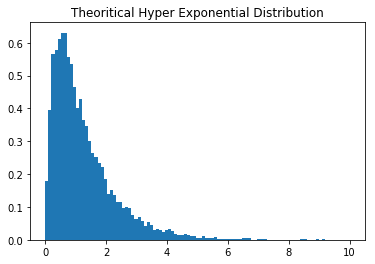

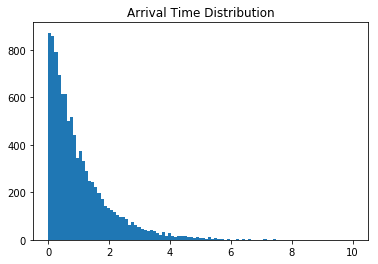

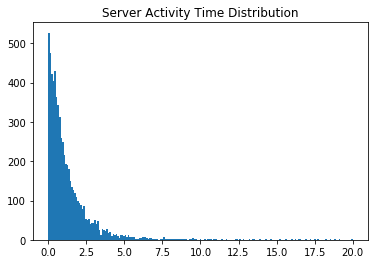

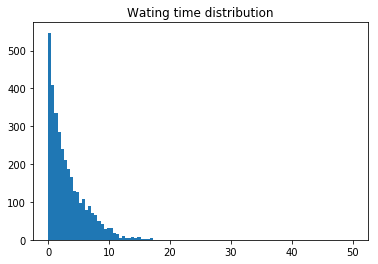

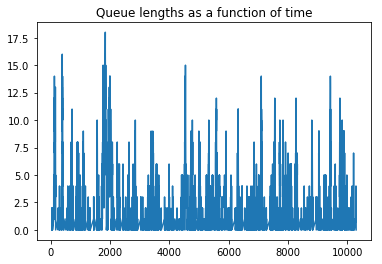

In [7]:
print("\nEnqueue prob. mean: {0:.6f}".format(enqueued.mean()))
print("Enqueue prob. var: {0:e}".format(enqueued.var(ddof=1)))
n = enqueued.shape[0]
inner = (enqueued.std(ddof=1)/np.sqrt(n))
alpha = 0.05
CI = [enqueued.mean()+inner*sts.t.ppf(alpha/2,df=n-1),enqueued.mean()+inner*sts.t.ppf(1-(alpha/2),df=n-1)]
print("Enqueue prob. CI: [{0:.6f},{1:.6f}]".format(*CI))


probs= -1/2*np.log(np.random.rand(10000))/2
probs = probs-1/2*np.log(np.random.rand(10000))*2

plt.figure()
plt.hist(probs,bins=np.linspace(0,10,100),density=True)
plt.title('Theoritical Hyper Exponential Distribution')
plt.figure()
plt.hist(s.arrivalTimes,bins=np.linspace(0,10,100))
plt.title('Arrival Time Distribution')

serviceActivityTimes = np.array(s.serviceActivityTimes)
plt.figure()
plt.hist(serviceActivityTimes,bins=np.linspace(0,20,200))
plt.title('Server Activity Time Distribution')

Ql = np.array(s.queue.Qlen)
Qt = np.array(s.queue.Qtime)
plt.figure()
plt.title('Wating time distribution')
plt.hist(Qt,bins=np.linspace(0,50,100))
plt.figure()
plt.title('Queue lengths as a function of time')
plt.plot(Ql[:,0],Ql[:,1])

### Erlangs C formula for expected customers enqueued

In [8]:
E = service_mean
m = num_servers

i = np.arange(m)
p_q = (((E**m)/factorial(m))*(m/(m-E)))/(np.sum(E**i/factorial(i))+((E**m/factorial(m))*(m/(m-E))))
print("Expected Enqueue prob.: {}".format(p_q))

Expected Enqueue prob.: 0.4091801507964435


### Run the simulator with an interrupted poisson process

In [9]:
num_servers = 10
service_mean = 8
w1 = 8
w2 = 8
lmbda = 1

interarrival_exp = lambda num: sts.expon.rvs(size=num,scale=1./lmbda)
service_exp = lambda num: sts.expon.rvs(size=num,scale=service_mean)
stateGenOnToOff = lambda num: sts.expon.rvs(size=num,scale=w1)
stateGenOffToOn = lambda num: sts.expon.rvs(size=num,scale=w2)
stateGen = (stateGenOnToOff,stateGenOffToOn)

num_runs = 100
num_departs = 10000
enqueued = np.zeros((num_runs,))
for run in range(num_runs):
    if (run+1) % 10 == 0:
        print("Run {} out of {}".format(run+1,num_runs))
    s = Simulation(num_servers=num_servers,interarrival=interarrival_exp,service=service_exp,
                   stateGen=stateGen,superpositions=1)
    while s.num_departed < num_departs:
        s.advanceTime()
    enqueued[run] = s.enqueued/num_departs

Run 10 out of 100
Run 20 out of 100
Run 30 out of 100
Run 40 out of 100
Run 50 out of 100
Run 60 out of 100
Run 70 out of 100
Run 80 out of 100
Run 90 out of 100
Run 100 out of 100


### Results from above


Enqueue prob. mean: 0.231391
Enqueue prob. var: 6.565780e-04
Enqueue prob. CI: [0.226307,0.236475]


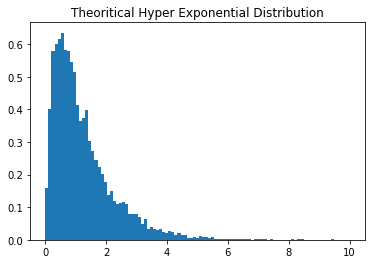

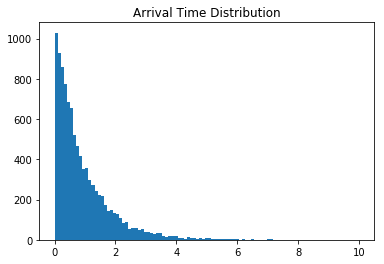

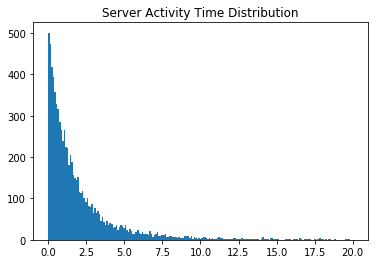

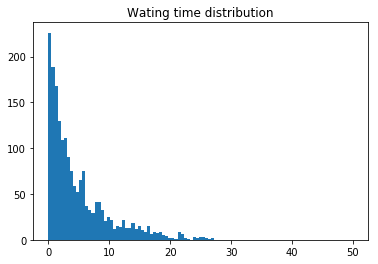

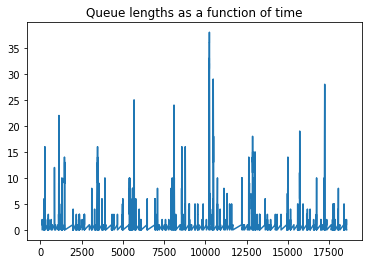

In [10]:
print("\nEnqueue prob. mean: {0:.6f}".format(enqueued.mean()))
print("Enqueue prob. var: {0:e}".format(enqueued.var(ddof=1)))
n = enqueued.shape[0]
inner = (enqueued.std(ddof=1)/np.sqrt(n))
alpha = 0.05
CI = [enqueued.mean()+inner*sts.t.ppf(alpha/2,df=n-1),enqueued.mean()+inner*sts.t.ppf(1-(alpha/2),df=n-1)]
print("Enqueue prob. CI: [{0:.6f},{1:.6f}]".format(*CI))


probs= -1/2*np.log(np.random.rand(10000))/2
probs = probs-1/2*np.log(np.random.rand(10000))*2

plt.figure()
plt.hist(probs,bins=np.linspace(0,10,100),density=True)
plt.title('Theoritical Hyper Exponential Distribution')
plt.figure()
plt.hist(s.arrivalTimes,bins=np.linspace(0,10,100))
plt.title('Arrival Time Distribution')

serviceActivityTimes = np.array(s.serviceActivityTimes)
plt.figure()
plt.hist(serviceActivityTimes,bins=np.linspace(0,20,200))
plt.title('Server Activity Time Distribution')

Ql = np.array(s.queue.Qlen)
Qt = np.array(s.queue.Qtime)
plt.figure()
plt.title('Wating time distribution')
plt.hist(Qt,bins=np.linspace(0,50,100))
plt.figure()
plt.title('Queue lengths as a function of time')
plt.plot(Ql[:,0],Ql[:,1])